In [1]:
import time
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import genjax
from genjax.typing import IntArray, Union, PRNGKey, Tuple
from genjax import GenerativeFunction, ChoiceMap, Selection, trace

sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = [9, 9]

# Pretty printing.
console = genjax.pretty(width=80)

# Reproducibility.
key = jax.random.PRNGKey(314159)

This notebook showcases critical performance attributes of GenJAX. It highlights speed ups in parallelism, fast gradient moves - but doesn't contain comparisons with other language implementations of Gen. The hardware characteristics of my experiment device is shown below.

In [2]:
! neofetch --stdout

mccoybecker@McCoys-MacBook-Air-2.local 
-------------------------------------- 
OS: macOS 13.1 22C65 arm64 
Host: Mac14,2 
Kernel: 22.2.0 
Uptime: 29 days, 10 hours, 53 mins 
Packages: 153 (brew) 
Shell: zsh 5.8.1 
Resolution: 1470x956 
DE: Aqua 
WM: Rectangle 
Terminal: iTerm2 
Terminal Font: PragmataProMonoLiga-Regular 18 (normal) / LigaSFMonoNerdFont-Regular 18 (non-ascii) 
CPU: Apple M2 
GPU: Apple M2 
Memory: 2421MiB / 16384MiB 



## Current modeling languages ~ static + combinators

The current set of modeling languages plus combinators is roughly equivalent to the (static modeling language plus combinators) subset of `Gen.jl`^[There are a few things that you can do beyond what is possible in the static modeling language (like use Python control flow evaluated at tracing time to perform codegen into the model) - but in general, these capabilities are syntactical sugar in nature.].

Let's create a polynomial regression model with degree selection and outlier detection.

In [3]:
# Branching model with two submodels.
switch = genjax.Switch(
    list(
        map(
            genjax.gen,
            [
                lambda pv: trace("value", genjax.Normal)(pv, 0.3),
                lambda pv: trace("value", genjax.Normal)(pv, 15.0),
            ],
        )
    )
)

# A model vectorized over `x` which calls the branching model.
@genjax.gen(genjax.Map, in_axes=(0, None, None))
def kernel(x, coefficients, basis_degrees):
    is_outlier = trace("outlier", genjax.Bernoulli)(0.1)
    is_outlier = jnp.asarray(is_outlier, dtype=int)
    polynomial_value = jnp.sum((x**basis_degrees) * coefficients)
    y = trace("y", switch)(is_outlier, polynomial_value)
    return y


# Here, `max_length` must be static at tracing time - it affects the shape
# of arrays in certain parts of the computation.
@genjax.gen
def model(xs):
    max_degree = 5
    coefficients = trace(
        "alpha", genjax.Map(genjax.TFPUniform, repeats=max_degree)
    )(-3.0, 3.0)
    basis_degrees = jnp.arange(max_degree)
    ys = trace("ys", kernel)(xs, coefficients, basis_degrees)
    return ys

Here, let's make a trace and examine it.

In [4]:
data = jnp.arange(-2.0, 2.0, 0.05)
key, tr = jax.jit(model.simulate)(key, (data,))
tr

BuiltinTrace
├── gen_fn
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── args
│   └── tuple
│       └──  f32[80]
├── retval
│   └──  f32[80]
├── choices
│   └── Trie
│       ├── :alpha
│       │   └── MapTrace
│       │       ├── gen_fn
│       │       │   └── MapCombinator
│       │       │       ├── in_axes
│       │       │       │   └── (const) None
│       │       │       ├── repeats
│       │       │       │   └── (const) 5
│       │       │       └── kernel
│       │       │           └── TFPDistribution
│       │       │               └── distribution
│       │       │                   └── (const) <class 
│       │       │                       'tensorflow_probability.substrates.jax.distributions.uniform.Uniform'>
│       │       ├── indices
│       │       │   └──  i32[5]
│       │       ├── inner
│       │       │   └── DistributionTrace
│       │       │       ├── gen_fn
│       │       │       │   └── TFPDistribution
│       │       │       │       └── distribution
│       │       │       │           └── (const) <class 
│       │       │       │               'tensorflow_probability.substrates.jax.distributions.uniform.Uniform'>
│       │       │       ├── args
│       │       │       │   └── tuple
│       │       │       │       ├──  f32[5]
│       │       │       │       └──  f32[5]
│       │       │       ├── value
│       │       │       │   └──  f32[5]
│       │       │       └── score
│       │       │           └──  f32[5]
│       │       └── score
│       │           └──  f32[]
│       └── :ys
│           └── MapTrace
│               ├── gen_fn
│               │   └── MapCombinator
│               │       ├── in_axes
│               │       │   └── tuple
│               │       │       ├── (const) 0
│               │       │       ├── (const) None
│               │       │       └── (const) None
│               │       ├── repeats
│               │       │   └── (const) None
│               │       └── kernel
│               │           └── BuiltinGenerativeFunction
│               │               └── source
│               │                   └── <function kernel>
│               ├── indices
│               │   └──  i32[80]
│               ├── inner
│               │   └── BuiltinTrace
│               │       ├── gen_fn
│               │       │   └── BuiltinGenerativeFunction
│               │       │       └── source
│               │       │           └── <function kernel>
│               │       ├── args
│               │       │   └── tuple
│               │       │       ├──  f32[80]
│               │       │       ├──  f32[80,5]
│               │       │       └──  i32[80,5]
│               │       ├── retval
│               │       │   └──  f32[80]
│               │       ├── choices
│               │       │   └── Trie
│               │       │       ├── :outlier
│               │       │       │   └── DistributionTrace
│               │       │       │       ├── gen_fn
│               │       │       │       │   └── _Bernoulli
│               │       │       │       ├── args
│               │       │       │       │   └── tuple
│               │       │       │       │       └──  f32[80]
│               │       │       │       ├── value
│               │       │       │       │   └──  bool[80]
│               │       │       │       └── score
│               │       │       │           └──  f32[80]
│               │       │       └── :y
│               │       │           └── SwitchTrace
│               │       │               ├── gen_fn
│               │       │               │   └── SwitchCombinator
│               │       │               │       └── branches
│               │       │               │           └── list
│               │       │               │               ├── BuiltinGenerativeFunction
│               │       │               │               │   └── source
│               │       │               │               │       └── <function <la

Let's visualize some samples from our model.

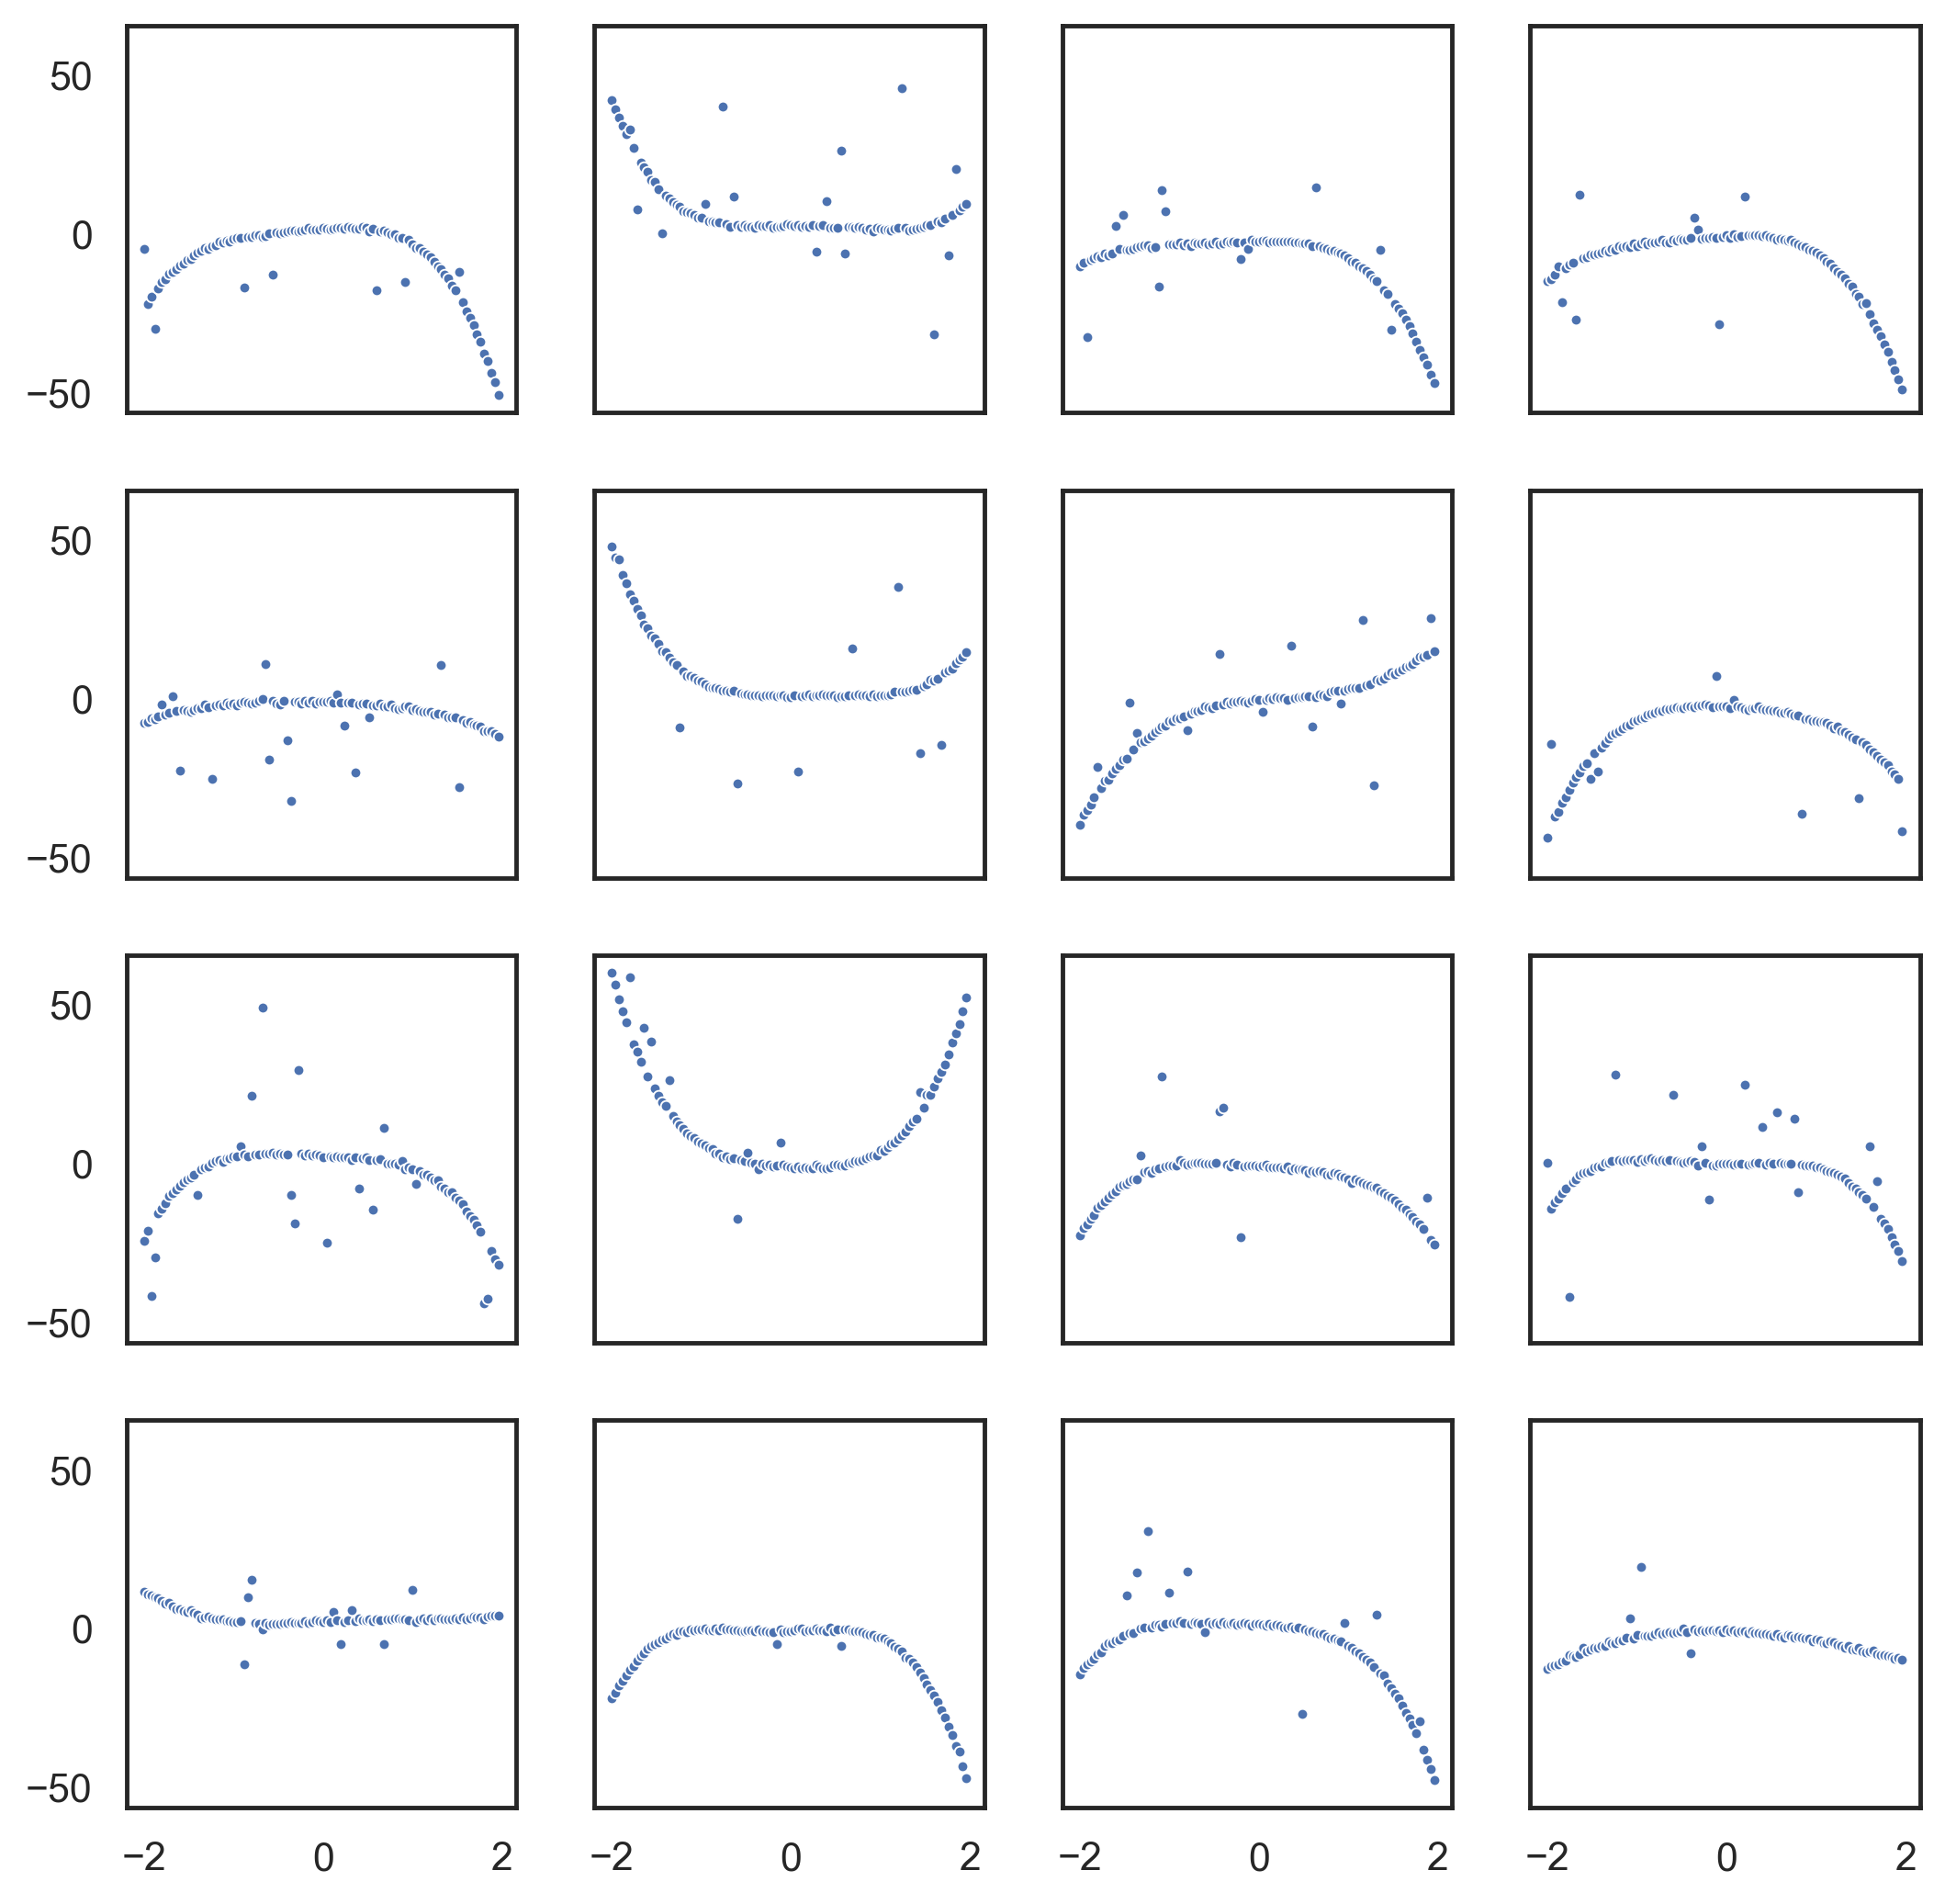

In [19]:
def viz(ax, x, y, **kwargs):
    (data,) = tr.get_args()
    chm = tr.get_choices()
    ys = np.array(chm["ys", "y", "value"])
    sns.scatterplot(x=x, y=y, ax=ax, **kwargs)


f, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=280)
jitted = jax.jit(model.simulate)
for ax in axes.flatten():
    key, tr = jitted(key, (data,))
    x = data
    y = tr.get_retval()
    viz(ax, x, y, marker=".")

plt.show()

## Benchmarking importance sampling (CPU vs. GPU)

Importance sampling (and SIR) are embarrassingly parallel. We can run an importance sampling routine and compare the performance characteristics on different devices.

Later on, we'll add ingredients to our importance sampling routine (like rejuvenation) - so here, we'll make the benchmark code re-usable.

In [6]:
def benchmark_inf(inf, key, *args, iters=100, device=jax.devices()[0]):
    jitted = jax.jit(inf, device=device)
    # warmup
    jitted(key, *args)
    times = []
    for i in range(0, iters):
        start = time.time()
        key, v = jitted(key, *args)
        v.block_until_ready()
        stop = time.time()
        times.append(stop - start)
    return np.array(times)

In [7]:
(genjax.ImportanceSampling, genjax.SamplingImportanceResampling)

(
    <class 'genjax._src.inference.importance_sampling.ImportanceSampling'>,
    <class 'genjax._src.inference.importance_sampling.SamplingImportanceResampling'>
)

Just for enlightenment - let's briefly look at the code for `ImportanceSampling`.

In [8]:
@dataclasses.dataclass
class ImportanceSampling(genjax.Pytree):
    num_particles: IntArray
    model: GenerativeFunction
    proposal: Union[None, GenerativeFunction] = None

    def flatten(self):
        return (), (self.num_particles, self.model, self.proposal)

    @classmethod
    def new(
        cls,
        num_particles: IntArray,
        model: GenerativeFunction,
        proposal: Union[None, GenerativeFunction] = None,
    ):
        return ImportanceSampling(
            num_particles,
            model,
            proposal=proposal,
        )

    def _bootstrap_importance_sampling(
        self,
        key: PRNGKey,
        observations: ChoiceMap,
        model_args: Tuple,
    ):
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, (lws, trs) = jax.vmap(
            self.model.importance, in_axes=(0, None, None)
        )(
            sub_keys,
            observations,
            model_args,
        )
        log_total_weight = jax.scipy.special.logsumexp(lws)
        log_normalized_weights = lws - log_total_weight
        log_ml_estimate = log_total_weight - jnp.log(self.num_particles)
        return key, (trs, log_normalized_weights, log_ml_estimate)

    def _proposal_importance_sampling(
        self,
        key: PRNGKey,
        observations: ChoiceMap,
        model_args: Tuple,
        proposal_args: Tuple,
    ):
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, p_trs = jax.vmap(self.proposal.simulate, in_axes=(0, None, None))(
            sub_keys,
            observations,
            proposal_args,
        )
        observations = jax.tree_util.map(
            lambda v: jnp.repeats(v, self.num_particles), observations
        )
        chm = p_trs.get_choices().merge(observations)
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, (lws, m_trs) = jax.vmap(
            self.model.importance, in_axes=(0, 0, None)
        )(
            sub_keys,
            chm,
            model_args,
        )
        lws = lws - p_trs.get_score()
        log_total_weight = jax.scipy.special.logsumexp(lws)
        log_normalized_weights = lws - log_total_weight
        log_ml_estimate = log_total_weight - jnp.log(self.num_particles)
        return key, (m_trs, log_normalized_weights, log_ml_estimate)

    def apply(self, key, choice_map: ChoiceMap, *args):
        # Importance sampling with custom proposal branch.
        if len(args) == 2:
            assert isinstance(args[0], tuple)
            assert isinstance(args[1], tuple)
            assert self.proposal is not None
            model_args = args[0]
            proposal_args = args[1]
            return self._proposal_importance_sampling(
                key, choice_map, model_args, proposal_args
            )
        # Bootstrap importance sampling branch.
        else:
            assert isinstance(args, tuple)
            assert self.proposal is None
            model_args = args[0]
            return self._bootstrap_importance_sampling(
                key, choice_map, model_args
            )

    def __call__(self, key, choice_map: ChoiceMap, *args):
        return self.apply(key, choice_map, *args)

Before we consider invoking this, let's generate a ground truth process.

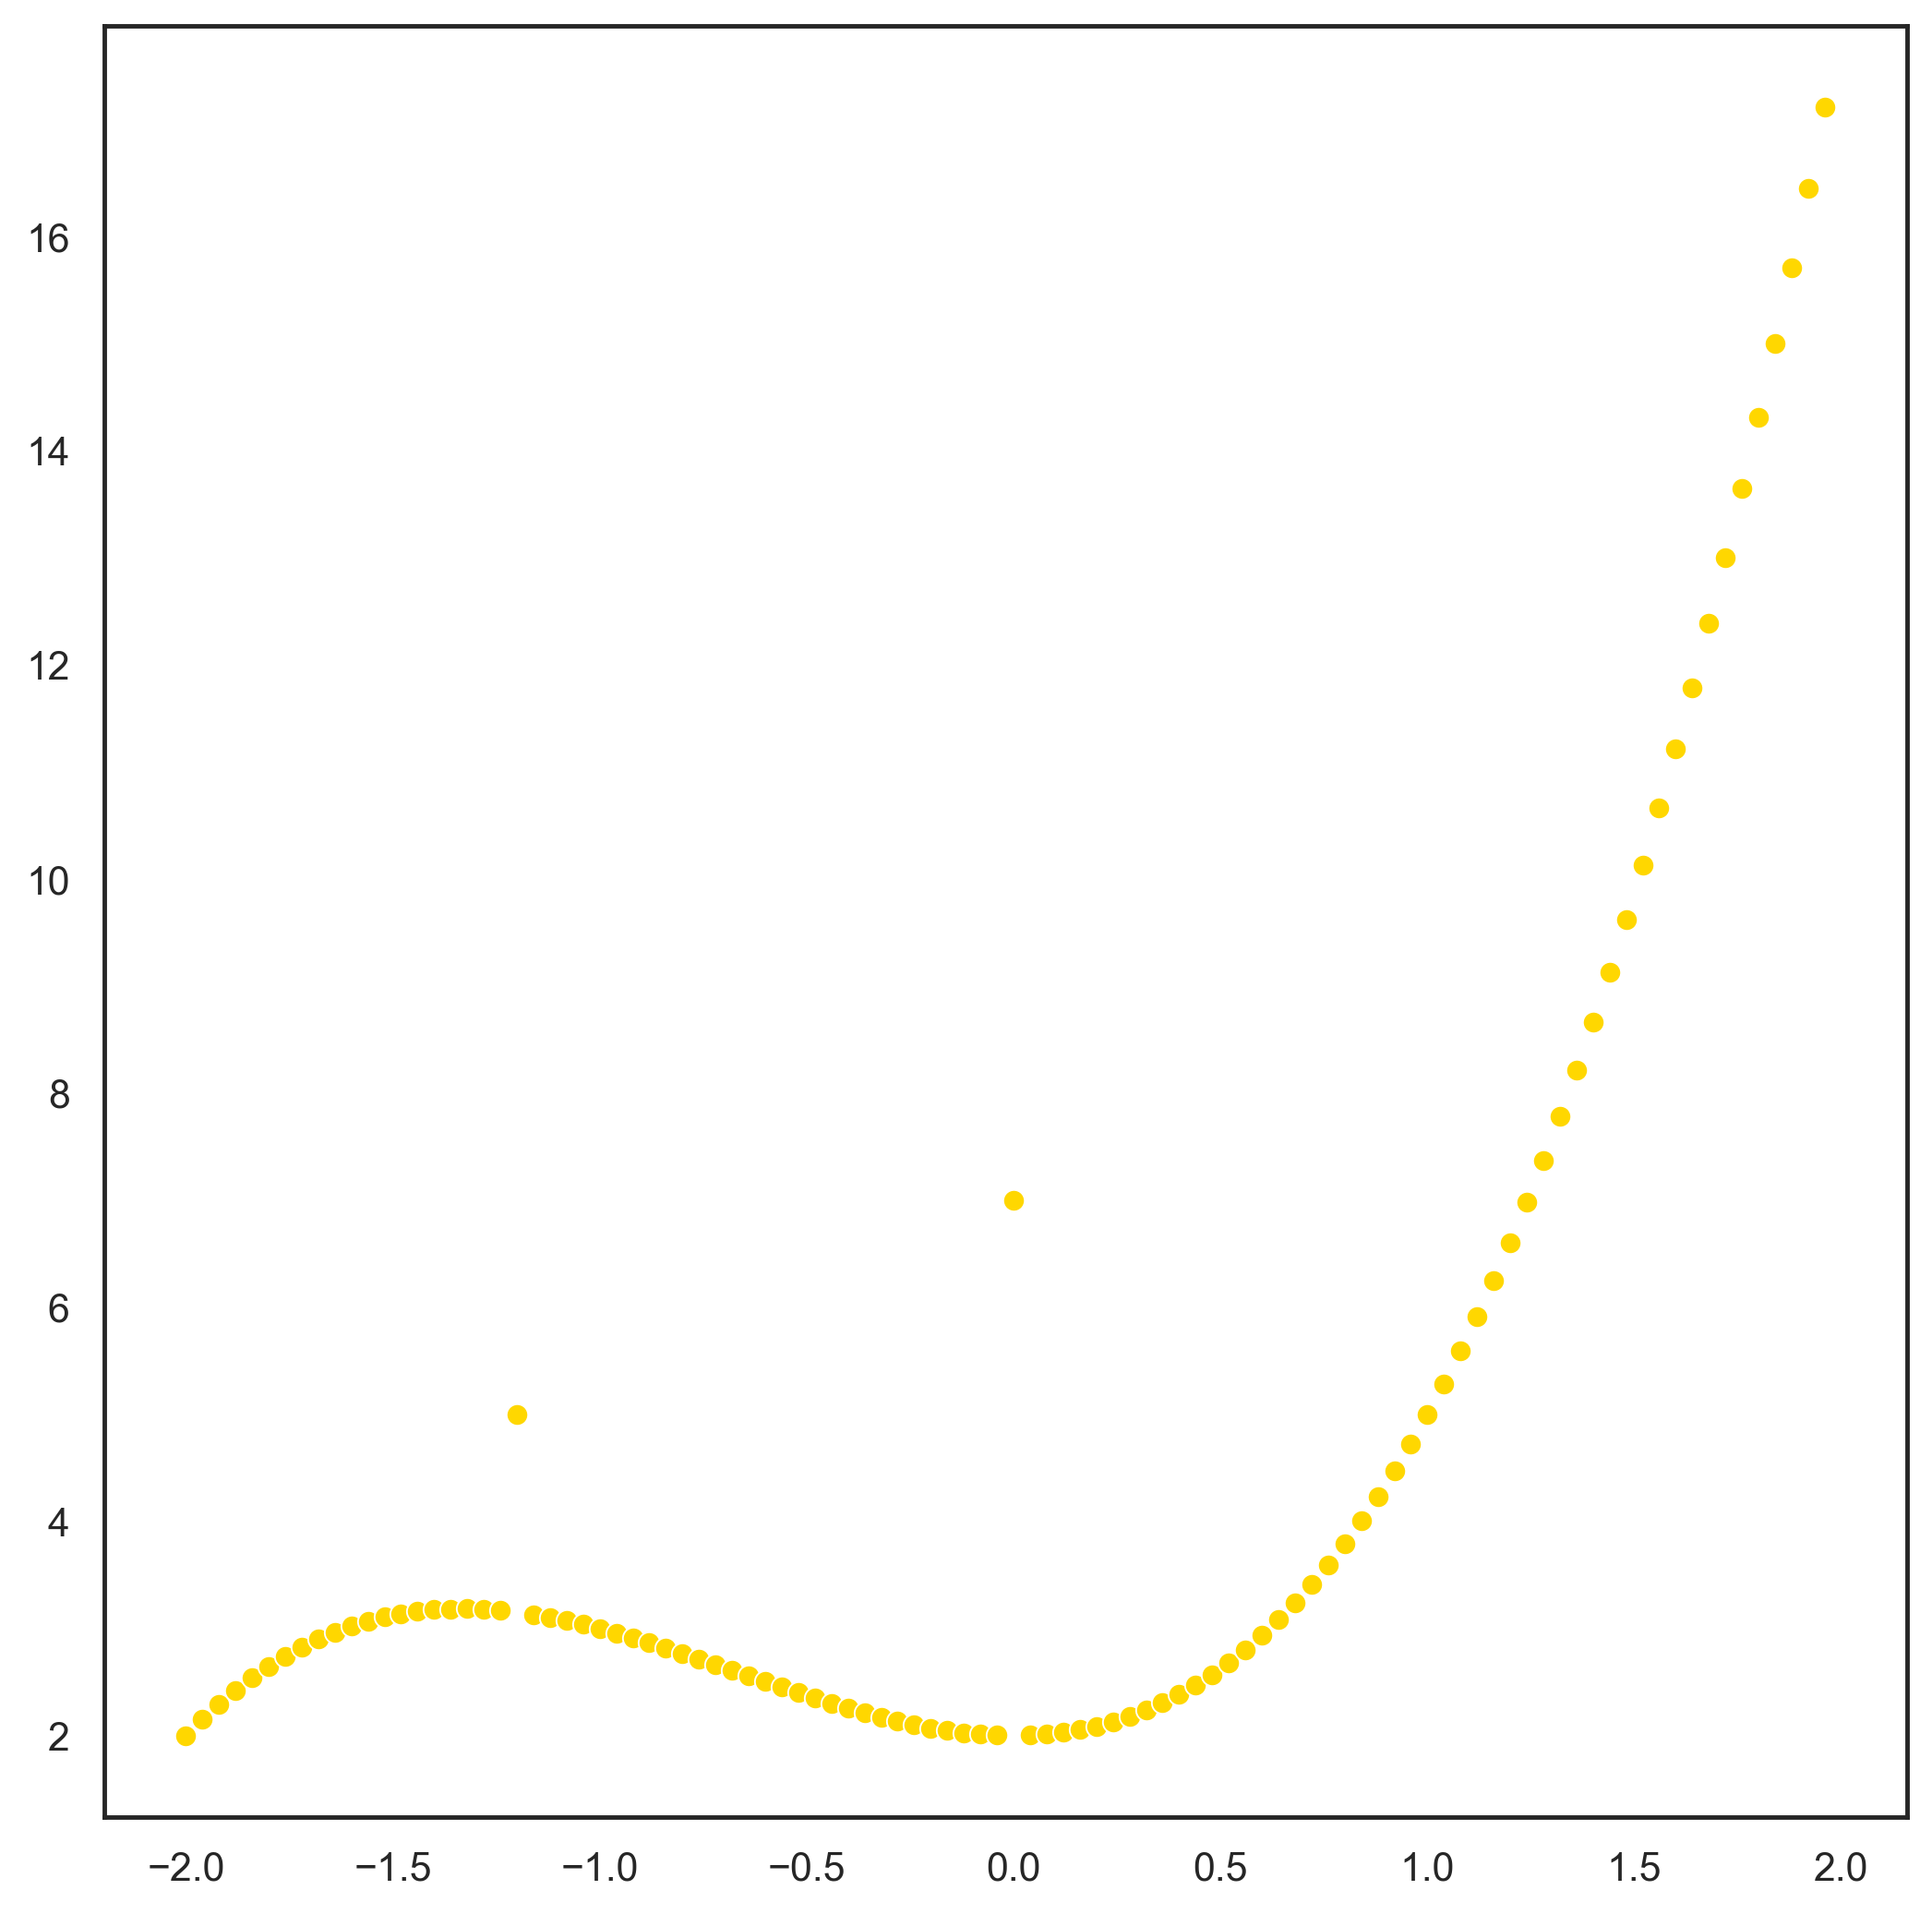

In [9]:
def make_data(num_data_points):
    data = np.arange(-2.0, 2.0, 4.0 / num_data_points)
    y = 2.0 * data**2 + 2.0 + data**3
    y[int(num_data_points / 2)] = 7.0
    y[int(num_data_points / 5)] = 5.0
    return data, y


data, y = make_data(100)
fig_data, ax_data = plt.subplots(dpi=280)
viz(ax_data, data, y, color="gold")

In [10]:
observations = genjax.choice_map(
    {"ys": genjax.vector_choice_map(genjax.choice_map({("y", "value"): y}))}
)
observations

BuiltinChoiceMap
└── trie
    └── Trie
        └── :ys
            └── VectorChoiceMap
                ├── indices
                │   └── (numpy) i64[100]
                └── inner
                    └── BuiltinChoiceMap
                        └── trie
                            └── Trie
                                └── :y
                                    └── Trie
                                        └── :value
                                            └── ValueChoiceMap
                                                └── value
                                                    └── (numpy) f64[100]

Here, `VectorChoiceMap` communicates constraints to `MapCombinator` (as well as `UnfoldCombinator`, but that's not featured in our model right now).

The indices describe, for each leaf element of the struct-of-array choice map shadowed by the `VectorChoiceMap`, what index of the `Map` invocation the value came from.

In [11]:
observations["ys"].indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

To invoke importance sampling, we can instantiate an instance of `ImportanceSampling`.

In [12]:
# 1000 particles.
inf = genjax.ImportanceSampling.new(1000, model)

In [13]:
# Benchmark function.
def _importance_sampling(key, *args):
    inf = genjax.ImportanceSampling.new(1000, model)
    key, (trs, _, _) = inf.apply(key, *args)
    score = jnp.mean(trs.get_score())
    return key, score


def benchmark_is(num_data_points, device=jax.devices()[0]):
    x, y = make_data(num_data_points)
    observations = genjax.choice_map(
        {
            "ys": genjax.vector_choice_map(
                genjax.choice_map({("y", "value"): y})
            )
        }
    )
    times = benchmark_inf(
        _importance_sampling, key, observations, (x,), device=device
    )
    return times


times = benchmark_is(200)
(np.mean(times), np.var(times))

(0.029222161769866944, 6.579145321399552e-05)

## Importance sampling with MH/MALA rejuvenation

Let's introduce two rejuvenation kernels, showcase their usage in inference, and then benchmark them.

In [14]:
mala_rejuv = genjax.mala(genjax.select(["alpha"]), 0.01)
mala_rejuv

MetropolisAdjustedLangevinAlgorithm
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               └── :alpha
│                   └── AllSelection
└── tau
    └── (const) 0.01

In [15]:
@genjax.gen
def proposal():
    is_outlier = trace("outlier", genjax.Bernoulli)(0.1)


mh_rejuv = genjax.mh(genjax.select(["outlier"]), proposal)
mh_rejuv

MetropolisHastings
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               └── :outlier
│                   └── AllSelection
└── proposal
    └── BuiltinGenerativeFunction
        └── source
            └── <function proposal>

In [16]:
# On-device rejuvenation chain.
def rejuv_chain(key, trs):
    def _inner(carry, xs):
        (keys, trs) = carry
        keys, trs = jax.vmap(mala_rejuv.apply, in_axes=(0, 0, None))(
            key, trs, ()
        )
        keys, trs = jax.vmap(mh.apply, in_axes=(0, 0, None))(key, trs, ())
        return (keys, trs), ()

    (_, trs), _ = jax.lax.scan(_inner, (keys, trs), length=50)
    return key, trs


# Benchmark function.
def _importance_sampling_rejuv(key, *args):
    inf = genjax.ImportanceSampling.new(1000, model)
    key, (trs, _, lmle) = inf.apply(key, *args)
    key, trs = rejuv_chain(key, trs)
    score = jnp.mean(trs.get_score())
    return key, score